In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import json
from fancyimpute import IterativeImputer
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_rows', None)
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wlsyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wlsyo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# 시드 고정
import os

SEED=42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

In [4]:
train = pd.read_csv("train.csv") # 학습용 데이터
test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [5]:
print(train.shape)
print(test.shape)

(59299, 29)
(5271, 30)


In [6]:
# 학습 타겟 데이터
targets=train['is_converted']
rows=train.shape[0]

with open('permitted.json','r') as f:
    permitted=json.load(f)

# 한번에 전처리를 위해 데이터 병합
train=train.drop('is_converted',axis=1)
test=test.drop('id',axis=1)
test=test.drop('is_converted',axis=1)
total_data=pd.concat([train,test])
#total_data=total_data.drop('is_converted',axis=1)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64570 entries, 0 to 5270
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     16356 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            19152 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  15031 non-null  float64
 8   id_strategic_ver         4037 non-null   float64
 9   it_strategic_ver         1174 non-null   float64
 10  idit_strategic_ver       5211 non-null   float64
 11  customer_job             44398 non-null  object 
 12  lead_desc_length         64570 non-null  int64  
 13  inquiry_type             62337 non-null  object 
 14  product_category       

In [7]:
# columns
cols_by_type={}

cols_by_type['categorical']=train.columns[train.dtypes=='object'].tolist()
cols_by_type['numerical']=train.columns[train.dtypes!='object'].tolist()
#colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(cols_by_type['numerical'])))
print('categorical columns: '+str(len(cols_by_type['categorical'])))
print('total columns: '+str(len(cols_by_type['numerical'])+len(cols_by_type['categorical'])))


numerical columns: 13
categorical columns: 15
total columns: 28


In [8]:
# delete cols
del_cols=['com_reg_ver_win_rate', 'ver_win_rate_x','ver_win_ratio_per_bu',
          'business_subarea', 'product_subcategory', 'product_modelname', 
          'customer_country.1']

# preserve
preserve=pd.DataFrame()
preserve['com_reg_ver_win_rate']=total_data['com_reg_ver_win_rate']

total_data=total_data.drop(del_cols,axis=1)

In [9]:
# id_strategic_ver it_strategic_ver idit_strategic_ver
ver=['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']
total_data['strategic_ver']=np.where(total_data['idit_strategic_ver']>0,1,0)
total_data=total_data.drop(ver,axis=1)

In [10]:
# country columns
# region
def preprocess_region(x,permitted):
    if type(x)==type(''):
        if permitted.get(x):
            return permitted[x]
        return 'OT'
    return np.nan

def preprocess_response_corporate(x,permitted):
    if type(x)==type(''):
        if permitted.get(x):
            return x
        return 'OT'
    return np.nan

def preprocess_customer_country(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace(' ','').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return word
        return 'OT'
    return np.nan

# region
total_data['region']=total_data['response_corporate'].apply(lambda x:preprocess_region(x,permitted=permitted['region']))

# response_corporate
total_data['response_corporate']=total_data['response_corporate'].apply(lambda x:preprocess_response_corporate(x,permitted=permitted['response_corporate']))

# customer_country   
total_data['customer_country']=total_data['customer_country'].apply(lambda x:preprocess_customer_country(x,permitted=permitted['customer_country']))

In [11]:
# business_unit
total_data['business_unit']=total_data['business_unit'].replace('Solution','ETC')
total_data['business_unit']=total_data['business_unit'].replace('CM','ETC')

In [12]:
# customer_type
def preprocess_customer_type(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('-','').replace(' ','')
        if permitted.get(x):
            return permitted[x]
        else:
            return 'OT'
    return x
    
total_data['customer_type']=total_data['customer_type'].apply(lambda x:preprocess_customer_type(x,permitted=permitted['customer_type']))

In [13]:
# business_area
total_data['business_area']=total_data['business_unit'].replace('hospital & health care','ETC')
total_data['business_area']=total_data['business_unit'].replace('factory','ETC')
total_data['business_area']=total_data['business_unit'].replace('government department','ETC')
total_data['business_area']=total_data['business_unit'].replace('public facility','ETC')
total_data['business_area']=total_data['business_unit'].replace('transportation','ETC')
total_data['business_area']=total_data['business_unit'].replace('power plant / renewable energy','ETC')

In [14]:
# ver_cus, ver_pro
grant=['ver_cus', 'ver_pro']
total_data['grant_weight']=np.where(total_data['ver_cus']>0,1,0)
total_data['grant_weight']=np.where(total_data['ver_pro']>0,1,total_data['grant_weight'])
total_data=total_data.drop(grant,axis=1)

In [15]:
# expected_timeline
def preprocess_expected_timeline(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace(' ','').replace('_','')
        if permitted.get(x):
            return permitted[x]
        return 'OT'
    return x

total_data['expected_timeline']=total_data['expected_timeline'].apply(lambda x:preprocess_expected_timeline(x,permitted=permitted['expected_timeline']))

In [16]:
# lead_desc_length
total_data['lead_desc_length']=np.log1p(total_data['lead_desc_length'])

# historical_existing_cnt
total_data['historical_existing_cnt']=np.log1p(total_data['historical_existing_cnt'])

In [17]:
# inquiry_type
def preprocess_inquiry_type(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('_',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

total_data['inquiry_type']=total_data['inquiry_type'].apply(lambda x:preprocess_inquiry_type(x,permitted=permitted['inquiry_type']))

In [18]:
# customer_job
def preprocess_customer_job(x,permitted):
    if type(x)==type(''):
        porter=PorterStemmer()
        tokens=word_tokenize(x)
        stems=[porter.stem(token) for token in tokens]
        for stem in stems:
            if permitted.get(stem):
                return permitted[stem]
        return 'OT'
    return np.nan

total_data['customer_job']=total_data['customer_job'].apply(lambda x:preprocess_customer_job(x,permitted=permitted['customer_job']))

In [19]:
# product_category
def preprocess_product_category(x,permitted):
    if type(x)==type(''):
        porter=PorterStemmer()
        tokens=word_tokenize(x)
        stems=[porter.stem(token) for token in tokens]

        prefer={}
        for pf in permitted['dump_key']:
            prefer[pf]=0
        
        for stem in stems:
            if permitted.get(stem):
                prefer[permitted[stem]]=1

        for pf in permitted['dump_key']:
            if prefer[pf]>0:
                return pf
        return 'OT'
    return np.nan

total_data['product_category']=total_data['product_category'].apply(lambda x:preprocess_product_category(x,permitted=permitted['product_category']))

In [20]:
# customer_poisition
def preprocess_customer_position(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('-',' ').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

total_data['customer_position']=total_data['customer_position'].apply(lambda x:preprocess_customer_position(x,permitted=permitted['customer_position']))

In [21]:
# business_area
total_data['business_area']=total_data['business_area'].fillna('UNK')

In [22]:
# customer_relationship
def user_labels_encoding(train_data,test_data):
    permit={}

    train_labels=train_data.value_counts()
    train_labels=sorted(train_labels.items(),key=lambda x:x[1],reverse=True)
    test_labels=test_data.value_counts()
    test_labels=sorted(test_labels.items(),key=lambda x:x[1],reverse=True)

    for test_label in test_labels[:100]:
        for train_label in train_labels[:100]:
            if test_label[0]==train_label[0]:
                permit[f'{test_label[0]}']=1
                break

    permit['dump_key']=1
    return permit

def preprocess_customer_relationship(x,permitted):
    x=str(x)
    if permitted.get(x):
        return 1
    return 0

train['customer_relationship']=train['customer_idx'].astype(str)+train['lead_owner'].astype(str)
test['customer_relationship']=test['customer_idx'].astype(str)+test['lead_owner'].astype(str)
total_data['customer_relationship']=total_data['customer_idx'].astype(str)+total_data['lead_owner'].astype(str)
permitted['customer_relationship']=user_labels_encoding(train['customer_relationship'],test['customer_relationship'])
total_data['customer_relationship']=total_data['customer_relationship'].apply(lambda x:preprocess_customer_relationship(x,permitted=permitted['customer_relationship']))

In [23]:
# customer_idx, lead_owner
def preprocess_user_labels(x,permitted):
    if x!=np.nan:
        x=str(x)
        if permitted.get(x):
            return x
        return 'OT'
    return np.nan

permitted['customer_idx']=user_labels_encoding(train['customer_idx'],test['customer_idx'])
permitted['lead_owner']=user_labels_encoding(train['lead_owner'],test['lead_owner'])
total_data['customer_idx']=total_data['customer_idx'].apply(lambda x:preprocess_user_labels(x,permitted=permitted['customer_idx']))
total_data['lead_owner']=total_data['lead_owner'].apply(lambda x:preprocess_user_labels(x,permitted=permitted['lead_owner']))


In [24]:
# columns
cols_by_type={}

cols_by_type['categorical']=total_data.columns[total_data.dtypes=='object'].tolist()
cols_by_type['numerical']=total_data.columns[total_data.dtypes!='object'].tolist()

print('\nnumerical columns: '+str(len(cols_by_type['numerical'])))
print('categorical columns: '+str(len(cols_by_type['categorical'])))
print('total columns: '+str(len(cols_by_type['numerical'])+len(cols_by_type['categorical'])))


numerical columns: 6
categorical columns: 14
total columns: 20


In [25]:
total_dummy=pd.get_dummies(total_data)

# nan data in numerical data
for col in cols_by_type['numerical']:
    total_dummy[col]=np.where(pd.isnull(total_data[col]),np.nan,total_dummy[col])

# nan data in objective data
for col in cols_by_type['categorical']:
    for value in total_data[col].value_counts().index:
        total_dummy[col+'_'+value]=np.where(pd.isnull(total_data[col]),np.nan,total_dummy[col+'_'+value])

In [26]:
from fancyimpute import IterativeImputer

imputer=IterativeImputer(random_state=SEED)
total_dummy.iloc[:,:]=imputer.fit_transform(total_dummy)
total_dummy.isnull().sum()

bant_submit                       0
historical_existing_cnt           0
lead_desc_length                  0
strategic_ver                     0
grant_weight                      0
customer_relationship             0
customer_country_OT               0
customer_country_brazil           0
customer_country_chile            0
customer_country_colombia         0
customer_country_egypt            0
customer_country_germany          0
customer_country_india            0
customer_country_italy            0
customer_country_mexico           0
customer_country_peru             0
customer_country_philippines      0
customer_country_poland           0
customer_country_saudiarabia      0
customer_country_u.a.e            0
customer_country_unitedkingdom    0
customer_country_unitedstates     0
customer_country_vietnam          0
business_unit_AS                  0
business_unit_ETC                 0
business_unit_ID                  0
business_unit_IT                  0
customer_idx_19804          

In [27]:
total_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64570 entries, 0 to 5270
Columns: 139 entries, bant_submit to region_OT
dtypes: float64(139)
memory usage: 69.0 MB


In [28]:
def decoding(origin_data,data_hot,object_columns):
    result=pd.DataFrame()
    for col in origin_data.columns:
        if col in object_columns:
            target_columns=[]
            for target_column in origin_data[col].value_counts().index:
                target_columns.append(col+'_'+target_column)
            result[col]=data_hot[target_columns].idxmax(axis=1).apply(lambda x:x.split('_')[-1])
        else:
            result[col]=data_hot[col]
    
    return result

object_columns=total_data.columns.to_list()
object_columns.remove('bant_submit')
object_columns.remove('historical_existing_cnt')
object_columns.remove('lead_desc_length')
object_columns.remove('strategic_ver')
object_columns.remove('grant_weight')
object_columns.remove('customer_relationship')
total_data_done=decoding(total_data,total_dummy,object_columns)

In [29]:
total_data_done['grant_weight']=total_data_done['grant_weight'].astype(int)
total_data_done['strategic_ver']=total_data_done['strategic_ver'].astype(int)
total_data_done['customer_relationship']=total_data_done['customer_relationship'].astype(int)
total_data_done.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64570 entries, 0 to 5270
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         64570 non-null  object 
 2   business_unit            64570 non-null  object 
 3   customer_idx             64570 non-null  object 
 4   customer_type            64570 non-null  object 
 5   enterprise               64570 non-null  object 
 6   historical_existing_cnt  64570 non-null  float64
 7   customer_job             64570 non-null  object 
 8   lead_desc_length         64570 non-null  float64
 9   inquiry_type             64570 non-null  object 
 10  product_category         64570 non-null  object 
 11  customer_position        64570 non-null  object 
 12  response_corporate       64570 non-null  object 
 13  expected_timeline        64570 non-null  object 
 14  business_area          

In [30]:
# com_reg_ver_win_rate
def impute_com_reg_ver_win_rate(x,permitted):
    if type(x)==type(''):
        return permitted[x]
    else:
        return x

total_data_done['com_reg_ver_win_rate']=preserve['com_reg_ver_win_rate']
total_data_done['com_reg_ver_win_rate']=np.where(total_data_done['com_reg_ver_win_rate'].isnull(),total_data_done['customer_country'],total_data_done['com_reg_ver_win_rate'])
total_data_done['com_reg_ver_win_rate']=total_data_done['com_reg_ver_win_rate'].apply(lambda x:impute_com_reg_ver_win_rate(x,permitted=permitted['com_reg_ver_win_rate']))

In [31]:
# new features
# region, customer_relationship pass

In [32]:
total_data_done.to_csv('confirm_done.csv')
total_data.to_csv('confirm.csv')

In [33]:
# split data
train_split=total_data_done[:rows]
test_split=total_data_done[rows:]

print(total_data_done.shape)
print(train_split.shape)
print(test_split.shape)

(64570, 21)
(59299, 21)
(5271, 21)


In [34]:
train_dummy=pd.get_dummies(train_split)
targets=targets.apply(lambda x:1 if x else 0)

# under sampling
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr=NeighbourhoodCleaningRule(kind_sel='all',n_neighbors=5)

down_X,down_y=ncr.fit_resample(train_dummy,targets)
print(down_X.shape)
print(down_y.shape)

(51357, 140)
(51357,)


In [35]:
# over sampling
# from imblearn.over_sampling import BorderlineSMOTE
# smt=BorderlineSMOTE(random_state=SEED,sampling_strategy=0.5)
# new_X,new_y=smt.fit_resample(down_X,down_y)
# print(new_X.shape)
# print(new_y.shape)

In [35]:
# deal new features
#object_columns.append('new_features')

train_data=decoding(train_split,down_X,object_columns)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51357 entries, 0 to 51356
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              51357 non-null  float64
 1   customer_country         51357 non-null  object 
 2   business_unit            51357 non-null  object 
 3   customer_idx             51357 non-null  object 
 4   customer_type            51357 non-null  object 
 5   enterprise               51357 non-null  object 
 6   historical_existing_cnt  51357 non-null  float64
 7   customer_job             51357 non-null  object 
 8   lead_desc_length         51357 non-null  float64
 9   inquiry_type             51357 non-null  object 
 10  product_category         51357 non-null  object 
 11  customer_position        51357 non-null  object 
 12  response_corporate       51357 non-null  object 
 13  expected_timeline        51357 non-null  object 
 14  business_area         

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from mlxtend.classifier import StackingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics         import mean_squared_error

In [37]:
#train_X,val_X,train_y,val_y=train_test_split(train_split,targets,test_size=0.2,shuffle=True,stratify=targets,random_state=SEED)

In [38]:
# 모델 성능 테스트
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    return F1

In [39]:
# focal loss
import math
from six.moves import xrange

class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        gamma = 2.
        # alpha = 1.
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1-p)**(gamma-1))*(gamma * math.log(p) * p + p - 1)/p
                der2 = gamma*((1-p)**gamma)*((gamma*p-1)*math.log(p)+2*(p-1))
            else:
                der1 = (p**(gamma-1)) * (gamma * math.log(1 - p) - p)/(1 - p)
                der2 = p**(gamma-2)*((p*(2*gamma*(p-1)-p))/(p-1)**2 + (gamma-1)*gamma*math.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result

In [40]:
# k-fold
targets=targets.apply(lambda x:1 if x else 0)

kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
cv_scores=[]

In [75]:
def modeling(n_estimators,max_depth,learning_rate,cat_features,train_data,targets_data,core='CPU'):
    models=[]
    scores=[]
    for i,(train_index,val_index) in enumerate(kf.split(train_data,targets_data)):
        print(f'-{i+1} fold-')
        X_train,X_val=train_data.iloc[train_index],train_data.iloc[val_index]
        y_train,y_val=targets_data.iloc[train_index],targets_data.iloc[val_index]

        # classes = np.unique(y_train)
        # weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        # class_weights = dict(zip(classes, weights))

        classifier=CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, eval_metric='F1', loss_function=FocalLossObjective(), random_state=SEED, bootstrap_type ='Bernoulli',task_type=core) # default:logloss
        model=classifier.fit(X_train, y_train, eval_set=(X_val,y_val),verbose=100, early_stopping_rounds=100,cat_features=cat_features,use_best_model=True)
        # regressor=CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, eval_metric='RMSE',random_state=SEED, bootstrap_type ='Bernoulli',task_type=core)
        # model=regressor.fit(X_train, y_train, eval_set=(X_val,y_val),verbose=100, early_stopping_rounds=100,cat_features=cat_features)
        
        pred=model.predict(X_val,prediction_type='RawFormulaVal')
        print(pred>0)
        #scores.append(get_clf_eval(y_val,pred))
        # scores.append(np.sqrt(mean_squared_error(y_val,pred)))
        
        
        models.append(model)
    print(f'F1 scores mean: {np.mean(scores)}')
    return models

In [76]:
cat_features=train_data.columns.to_list()
cat_features.remove('bant_submit')
cat_features.remove('lead_desc_length')
cat_features.remove('historical_existing_cnt')
cat_features.remove('com_reg_ver_win_rate')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51357 entries, 0 to 51356
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              51357 non-null  float64
 1   customer_country         51357 non-null  object 
 2   business_unit            51357 non-null  object 
 3   customer_idx             51357 non-null  object 
 4   customer_type            51357 non-null  object 
 5   enterprise               51357 non-null  object 
 6   historical_existing_cnt  51357 non-null  float64
 7   customer_job             51357 non-null  object 
 8   lead_desc_length         51357 non-null  float64
 9   inquiry_type             51357 non-null  object 
 10  product_category         51357 non-null  object 
 11  customer_position        51357 non-null  object 
 12  response_corporate       51357 non-null  object 
 13  expected_timeline        51357 non-null  object 
 14  business_area         

In [77]:
cats=modeling(n_estimators=10000,max_depth=10,learning_rate=0.03,cat_features=cat_features,train_data=train_data,targets_data=down_y)

-1 fold-
0:	learn: 0.0030872	test: 0.0000000	best: 0.0000000 (0)	total: 345ms	remaining: 57m 27s
100:	learn: 0.1195547	test: 0.1196911	best: 0.1196911 (98)	total: 9.45s	remaining: 15m 25s
200:	learn: 0.3393991	test: 0.3386689	best: 0.3386689 (200)	total: 23.4s	remaining: 19m 1s
300:	learn: 0.4629988	test: 0.4582375	best: 0.4582375 (300)	total: 38.6s	remaining: 20m 42s
400:	learn: 0.5601005	test: 0.5372493	best: 0.5372493 (399)	total: 54.8s	remaining: 21m 52s
500:	learn: 0.6236559	test: 0.5767378	best: 0.5777471 (492)	total: 1m 11s	remaining: 22m 29s
600:	learn: 0.6687676	test: 0.6048387	best: 0.6061828 (586)	total: 1m 28s	remaining: 23m 7s
700:	learn: 0.7080564	test: 0.6270627	best: 0.6283828 (692)	total: 1m 46s	remaining: 23m 36s
800:	learn: 0.7382614	test: 0.6406250	best: 0.6423927 (799)	total: 2m 4s	remaining: 23m 45s
900:	learn: 0.7651822	test: 0.6550837	best: 0.6559486 (892)	total: 2m 21s	remaining: 23m 50s
1000:	learn: 0.7863274	test: 0.6649649	best: 0.6658147 (982)	total: 2m 39s

KeyboardInterrupt: 

In [47]:
test_pred=pd.Series([0 for x in range(len(test_split))], index=test_split.index)
#test_pred=pd.DataFrame()
for i,model in enumerate(cats):
    #test_pred['model'+str(i)]=model.predict(test_split)
    test_pred+=model.predict(test_split)
test_pred=test_pred/5
test_pred=test_pred.apply(lambda x:1 if x==1 else 0)

In [48]:
test_pred.value_counts()

0    3712
1    1559
dtype: int64

In [46]:
train_X,val_X,train_y,val_y=train_test_split(train_split,targets,test_size=0.2,shuffle=True,stratify=targets,random_state=SEED)
val_pred=pd.Series([0 for x in range(len(val_y))], index=val_y.index)
for i,model in enumerate(cats):
    val_pred+=model.predict(val_X)
val_pred=val_pred/5
val_pred=val_pred.apply(lambda x:1 if x==1 else 0)
get_clf_eval(val_y,val_pred)

오차행렬:
 [[ 872   98]
 [1498 9392]]

정확도: 0.8654
정밀도: 0.3679
재현율: 0.8990
F1: 0.5222


0.5221556886227545

In [115]:
#train_X,val_X,train_y,val_y=train_test_split(train_split,targets,test_size=0.2,shuffle=True,stratify=targets,random_state=SEED)
classifier=CatBoostClassifier(n_estimators=15000, max_depth=12, learning_rate=0.05, eval_metric='F1', random_state=SEED, bootstrap_type ='Bernoulli')
model=classifier.fit(train_data,down_y,eval_set=(train_data,down_y),verbose=100, early_stopping_rounds=50,cat_features=cat_features)
# pred=model.predict(val_X)
# get_clf_eval(val_y,pred)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 109ms	remaining: 27m 19s


KeyboardInterrupt: 

In [118]:
pred=model.predict(test_split)

In [120]:
pred.sum()

785

In [49]:
#test_pred=model.predict(test_split)
submission=pd.read_csv('submission.csv')
submission['is_converted']=test_pred

submission.to_csv('submission.csv',index=False)
submission.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,0
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,1
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1


In [50]:
# from catboost import Pool

feat_imp=cats[1].get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,lead_owner,14.573640
1,lead_desc_length,14.298133
2,customer_idx,9.517758
3,com_reg_ver_win_rate,8.617835
4,historical_existing_cnt,6.274278
5,response_corporate,5.938985
6,region,4.602889
7,inquiry_type,4.533684
8,business_area,4.356616
9,customer_country,4.317512


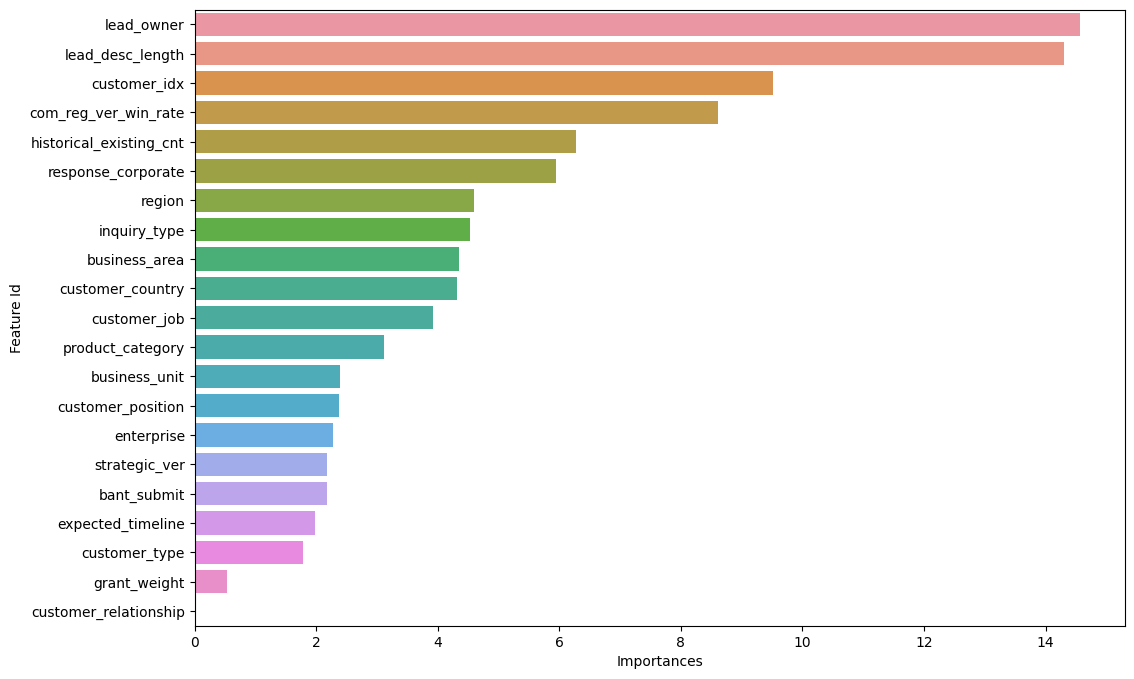

In [52]:
# Plotting top 20 features' importance

plt.figure(figsize = (12,8))
sns.barplot(x=feat_imp['Importances'][:20],y=feat_imp['Feature Id'][:21], orient = 'h')
plt.show()

In [124]:
submission['is_converted'].value_counts()

0    4486
1     785
Name: is_converted, dtype: int64